# Portfolio Optimization with Evolutionary Algorithms

---

**Project Goal:** Optimize a stock portfolio from the WIG20 index using classical Markowitz theory and Evolutionary Algorithms.

**Authors:** Wojciech Fiołka (fiolkawojciech@gmail.com), Igor Jakus (igorjakus@protonmail.com)


## 0. Wczytanie danych rynkowych


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interactive
from IPython.display import clear_output, display

# Importy z modułów src
from src.data import load_raw_data, process_returns
from src.utils import optimize_markowitz
from src.evolution import setup_deap, run_nsga2
import src.plots as plots

%matplotlib inline
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 11
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

In [ ]:
WIG20_TICKERS = sorted(
    [
        "ALR.WA",
        "ALE.WA",
        "ASB.WA",
        "BDX.WA",
        "CDR.WA",
        "CPS.WA",
        "DNP.WA",
        "JSW.WA",
        "KGH.WA",
        "KRU.WA",
        "LPP.WA",
        "MBK.WA",
        "OPL.WA",
        "PCO.WA",
        "PEP.WA",
        "PGE.WA",
        "PKN.WA",
        "PKO.WA",
        "PZU.WA",
        "SPL.WA",
    ]
)

full_data = load_raw_data(WIG20_TICKERS)
prices = full_data["Close"].ffill()
prices.tail()

Ticker,ALE.WA,ALR.WA,ASB.WA,BDX.WA,CDR.WA,CPS.WA,DNP.WA,JSW.WA,KGH.WA,KRU.WA,LPP.WA,MBK.WA,OPL.WA,PCO.WA,PEP.WA,PGE.WA,PKN.WA,PKO.WA,PZU.WA,SPL.WA
Date,,,,,,,,,,,,,,,,,,,,
2026-01-05,31.360001,114.500000,33.700001,636.599976,239.399994,12.600,41.090000,23.950001,296.500000,498.500000,21340.0,1066.0,10.085,31.090000,56.799999,9.018,99.750000,87.459999,68.139999,556.200012
2026-01-07,32.805000,115.300003,32.779999,686.200012,246.100006,13.085,42.369999,25.350000,294.399994,504.799988,21450.0,1100.0,10.410,31.230000,56.599998,9.336,99.620003,86.660004,71.580002,569.200012
2026-01-08,32.160000,113.800003,32.799999,676.000000,235.000000,12.760,41.439999,25.100000,280.299988,497.000000,20980.0,1056.0,10.200,30.889999,56.000000,9.066,92.580002,86.400002,71.199997,567.200012
2026-01-09,32.099998,113.099998,33.759998,669.799988,240.600006,13.225,42.200001,25.250000,297.799988,503.200012,21170.0,1048.5,10.440,31.100000,56.599998,9.310,96.190002,87.379997,70.000000,556.200012
2026-01-12,32.250000,113.849998,34.240002,667.000000,241.000000,13.220,41.990002,25.500000,303.000000,487.299988,20480.0,1059.0,10.320,30.820000,56.000000,9.238,98.849998,88.739998,69.440002,559.599976


## 1. Notowania spółek giełdowych


In [ ]:
ui_plot = interactive(lambda stock_name: plots.plot_close_price(stock_name, prices), stock_name=prices.columns.tolist())
display(ui_plot)

interactive(children=(Dropdown(description='stock_name', options=('ALE.WA', 'ALR.WA', 'ASB.WA', 'BDX.WA', 'CDR…

## 2. Stopy zwrotu spółek giełdowych


Rozpatrujemy $d$ spółek giełdowych, $\mathcal{A}_1, \mathcal{A}_2, \ldots, \mathcal{A}_d$. Niech $v^i_t$ oznacza wartość akcji spółki $\mathcal{A}_i$ w dniu $t$ (dla celów obliczeniowych, przyjmujemy, że wartość akcji jest określana przez cenę zamknięcia). _Stopą zwrotu_ spółki $\mathcal{A}_i$ w dniu $t$ nazywamy $$r^i_t = \frac{v^i_t - v^i_{t-1}}{v^i_{t-1}}.$$

Niech $t_0$ będzie ustalonym przyszłym dniem. Zakładamy w związku z tym, że nie mamy informacji o notowaniach spółek giełdowych w dniu $t_0$, ale znamy notowania z dni poprzednich. Stopę zwrotu spółki $\mathcal{A}_i$ w dniu $t_0$ traktujemy więc jako zmienną losową, oznaczmy ją przez $R_i$, i możemy określić oczekiwaną stopę zwrotu $\mathbb{E}[R_i]$ oraz wariancję stopy zwrotu $\mathbb{Var}[R_i]$ estymując je na okresie ostatnich $\Delta t$ dni, czyli na okresie $[t_0 - \Delta t, t_0 - 1]$. Analogicznie, oznaczając przez $\mathbf{R} = (R_1, R_2, \ldots, R_d)^T$ wektor losowy stóp zwrotu wszystkich rozpatrywanych spółek, możemy określić kowariancje $\mathbb{Cov}[\mathbf{R}]$ i korelacje $\mathbb{Corr}[\mathbf{R}]$ stóp zwrotu. Zatem:

- oczekiwaną stopę zwrotu $\mathbb{E}[R_i]$ spółki $\mathcal{A}_i$ w dniu $t_0$ definiujemy jako średnią stopą zwrotu z ostatnich $\Delta t$ dni, czyli z okresu $[t_0 - \Delta t, t_0 - 1]$,

- wariancję $\mathbb{Var}[R]$ spółki $\mathcal{A}_i$ w dniu $t_0$ definiujemy jako wariancję na ostatnich $\Delta t$ dniach, czyli na okresie $[t_0 - \Delta t, t_0 - 1]$,

- zależności między spółkami w dniu $t_0$ określamy przez kowariancję/korelację ich stóp zwrotu na ostatnich $\Delta t$ dniach, czyli na okresie $[t_0 - \Delta t, t_0 - 1]$.

<hr>
<b>UWAGA:</b> Przez <i>dzień</i> rozumiem tutaj <i>dzień roboczy</i>, a nie <i>dzień kalendarzowy</i>. Prowadzi to do pewnych nieścisłości (stopa zwrotu dla poniedziałku to de facto trzydniowa stopa zwrotu), bo tak liczone stopy zwrotu różnią się od stóp zwrotu liczonych zazwyczaj dla instrumentów pozbawionych ryzyka, m.in. lokat bankowych, gdzie oprocentowanie liczy się dla wszystkich dni kalendarzowych.

<hr>
Poniższe przykładowe obliczenia ilustrują estymowanie oczekiwanej stopy zwrotu i wariancji dla ostatniego dnia zarejestrowanych notowań.


In [ ]:
stats = process_returns(prices, delta_t=365)

# Rozpakowanie statystyk dla wygody
stock_names = np.array(stats["valid_tickers"])
stock_returns_m = stats["returns_m"]
stock_returns_s = stats["returns_s"]
stock_covariances = stats["covariances"]
stock_correlations = stats["correlations"]

print(f"Przeanalizowano {len(stock_names)} spółek.")

Przeanalizowano 20 spółek.


### 2.1. Oczekiwana stopa zwrotu i ryzyko (określone przez wariancję stopy zwrotu) rozpatrywanych spółek


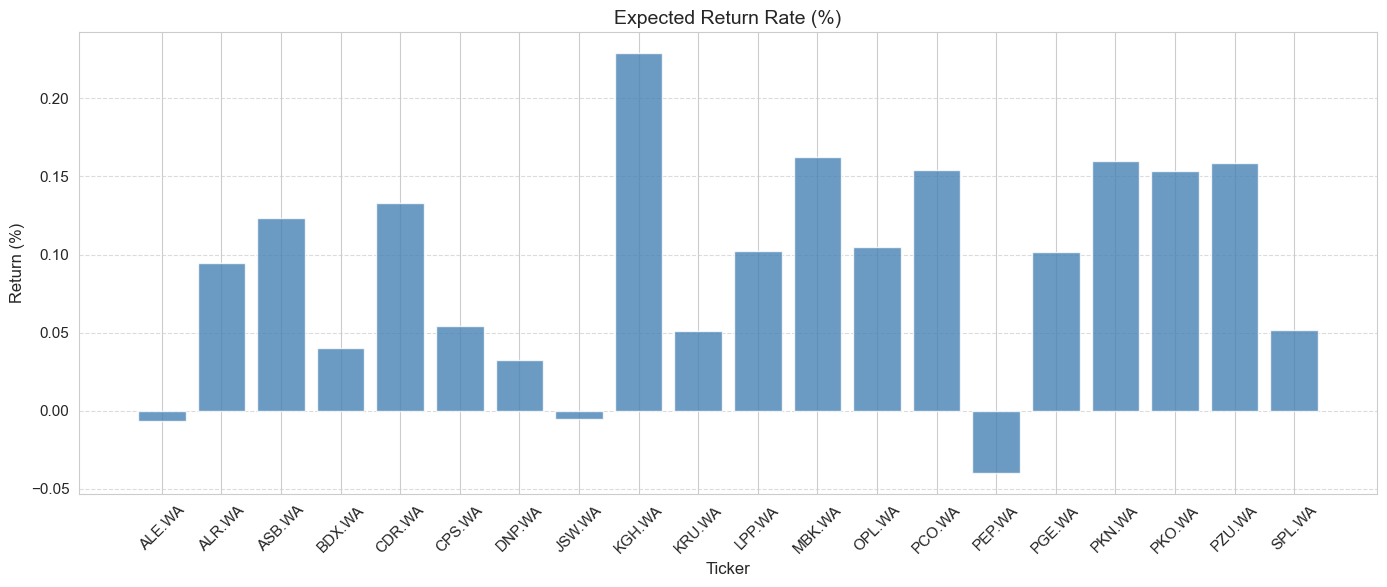

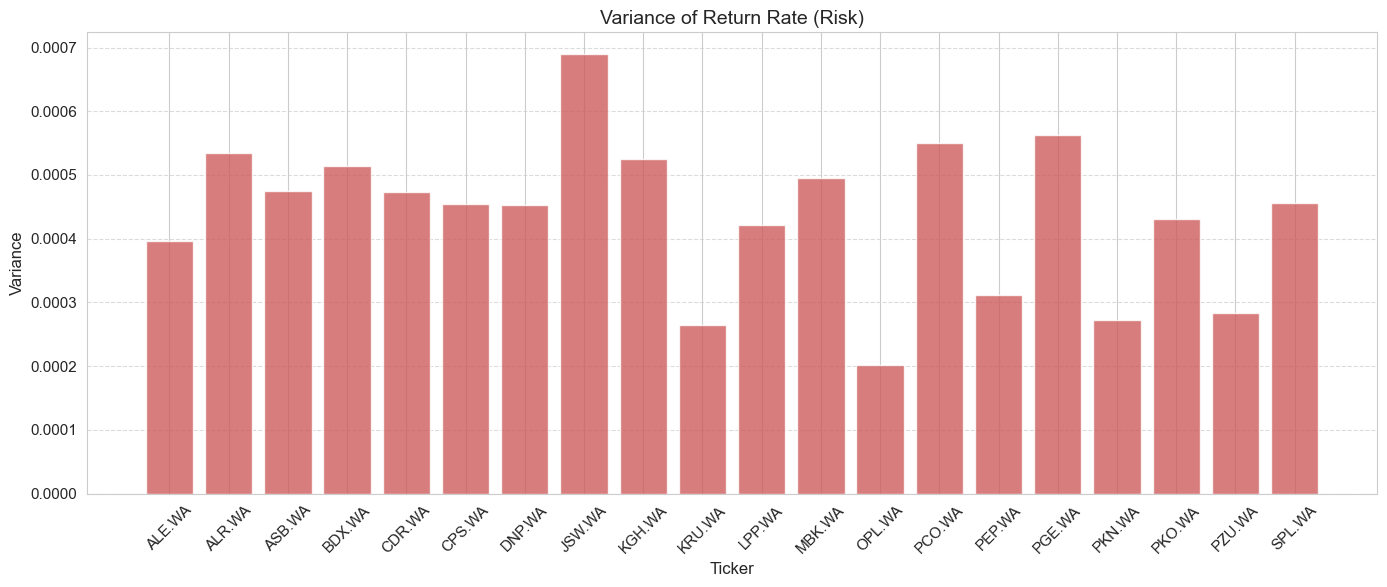

In [ ]:
plots.plot_returns_and_risk(stock_returns_m, stock_returns_s)

### 2.2. Korelacja stóp zwrotu rozpatrywanych spółek


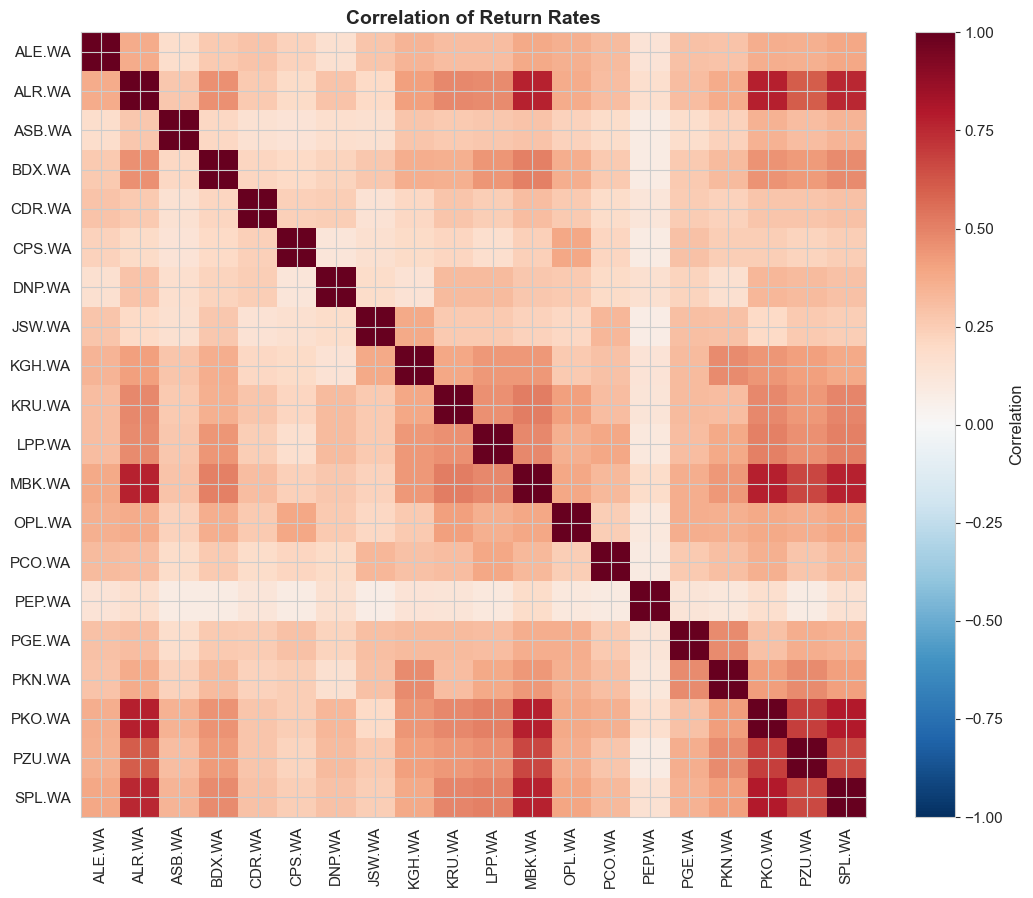

In [ ]:
plots.plot_correlations(stock_correlations)

### 2.3. Spółki dominujące, zdominowane i niezdominowane

Zastanawiając się w którą spółkę giełdową zainwestować kapitał, rozważamy dwa parametry: oczekiwaną stopę zwrotu inwestycji oraz ryzyko inwestycji (definiowane przez wariancję stopy zwrotu). Rozpatrując zbiór spółek giełdowych, można wprowadzić pojęcia _spółki dominującej_ i _spółki zdominowanej_ w następujący sposób:

- Mówimy, że spółka giełdowa $\mathcal{A}$ dominuje spółkę giełdową $\mathcal{B}$, jeżeli oczekiwana stopa zwrotu spółki $\mathcal{A}$ jest nie niższa niż spółki $\mathcal{B}$ oraz ryzyko spółki $\mathcal{A}$ jest niższe niż ryzyko spółki $\mathcal{B}$ .
- Spółka $\mathcal{B}$ jest spółką zdominowaną, jeśli istnieje spółka $\mathcal{A}$, która ją dominuje.
- Spółka $\mathcal{B}$ jest spółką niezdominowaną, jeśli nie istnieje spółka $\mathcal{A}$, która ją dominuje.


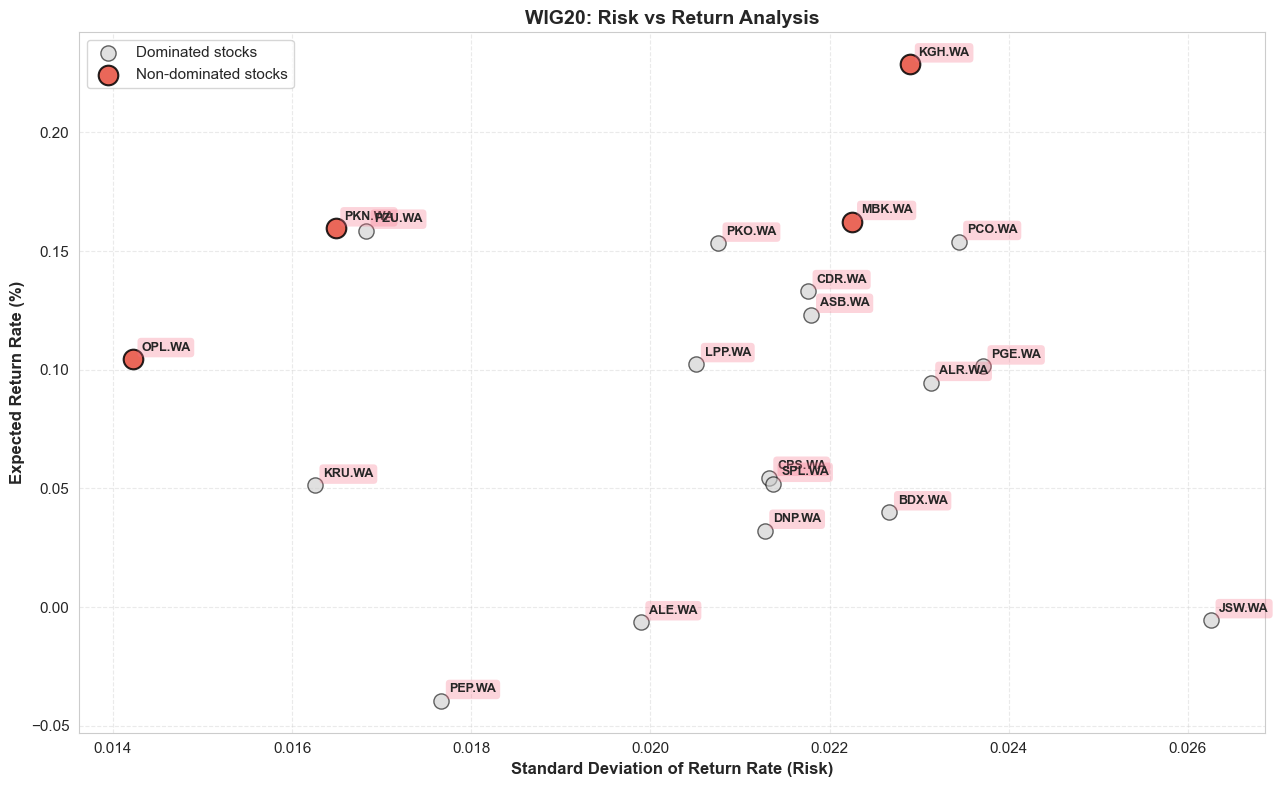

In [ ]:
plots.plot_dominance(stock_returns_m, stock_returns_s)

## 3. Teoria portfela Markowitza


Zamiast zastanawiać się w którą spółkę giełdową zainwestować cały kapitał, można zastanawiać się jak podzielić rozpatrywany kapitał na części i zainwestować je w poszczególne spółki (stworzyć _portfel_ inwestycji).


### 3.1. Wprowadzenie

Niech $\mathbf{R} = (R_1, R_2, \ldots, R_d)^T$ oznacza wektor losowy stóp zwrotu wszystkich rozpatrywanych spółek.

Niech $\boldsymbol{\mu} = (\mu_1, \mu_2, \ldots, \mu_d)^T = \mathbb{E}[\mathbf{R}] \in \mathbb{R}^d$ oznacza wektor oczekiwanych stóp zwrotu rozpatrywanych spółek.

Niech $\boldsymbol{\Sigma} = \mathbb{Cov}[\mathbf{R}] \in \mathbb{R}^{d \times d}$ oznacza macierz kowariancji stóp zwrotu rozpatrywanych spółek.

Zakładamy, że rozpatrywane spółki są instrumentami obarczonymi ryzykiem, czyli wariancja ich stóp zwrotu jest niezerowa (dokładniej: zakładamy, że macierz kowariancji $\boldsymbol{\Sigma}$ jest dodatnio określona - skąd wynika, że jest macierzą odwracalną).

_Portfelem_ nazywamy wektor $\mathbf{p} = (p_1, p_2, \ldots, p_d)^T \in \mathbb{R}^d$, taki że $\sum_{i=1}^d p_i = 1$, który definiuje rozbicie kapitału na części do zainwestowania w poszczególne spółki ($p_i$ to wielkość kapitału do zainwestowania w spółkę $\mathcal{A}_i$).

Stopa zwrotu portfela $\mathbf{p}$ jest więc zmienną losową $R_\mathbf{p} = \mathbf{p}^T \mathbf{R}$.

Oczekiwana stopa zwrotu portfela wynosi zatem $\mathbb{E}[R_\mathbf{p}] = \mathbb{E}[\mathbf{p}^T \mathbf{R}] = \mathbf{p}^T \mathbb{E}[\mathbf{R}] = \mathbf{p}^T \boldsymbol{\mu}$.

Ryzyko portfela, określone przez wariancję jego stopy zwrotu, wynosi zatem $\mathbb{Var}[R_\mathbf{p}] = \mathbb{Var}[\mathbf{p}^T \mathbf{R}] = \mathbf{p}^T \mathbb{Cov}[\mathbf{R}] \mathbf{p} = \mathbf{p}^T \boldsymbol{\Sigma} \mathbf{p}$.


<div style="background-color:rgba(0, 0, 0, 0.15)">
<b>UWAGA</b>: Powyższe podejście teoretyczne nie pokrywa się z podejściem obliczeniowym (wartość oczekiwana i wariancja stopy zwrotu portfela estymowana na podstawie jego wartości w ustalonym okresie nie pokrywają się z wartościami liczonymi według powyższych wzorów).

Pozornie, dla ustalonego dnia $t_0$, oczekiwaną stopę zwrotu portfela (i analogicznie jej wariancję), można byłoby określić estymując je na okresie ostatnich $\Delta t$ dni, czyli na okresie $[t_0 - \Delta t + 1, t_0]$.

Portfel definuje jaka część całkowitego kapitału (domyślnie równego 1) jest inwestowana w poszczególne spółki: w $i$-tą spółkę inwestowane jest $p_i$, czyli kupowane jest $\frac{p_i}{v^i_{t_0}}$ akcji tej spółki. Zatem, całkowita wartość takiego portfela w dniu $t$ wynosiła $$\sum_{i=1}^d \frac{p_i}{v^i_{t_0}} v^i_t,$$ czyli stopa zwrotu takiego portfela w dniu $t$ wynosiła $$\frac{\sum_{i=1}^d \frac{p_i}{v^i_{t_0}} v^i_t - \sum_{i=1}^d \frac{p_i}{v^i_{t_0}} v^i_{t-1}}{\sum_{i=1}^d \frac{p_i}{v^i_{t_0}} v^i_{t-1}} = \frac{\sum_{i=1}^d \frac{p_i}{v^i_{t_0}} (v^i_t - v^i_{t-1})}{\sum_{i=1}^d \frac{p_i}{v^i_{t_0}} v^i_{t-1}} = \frac{\sum_{i=1}^d p_i r^i_t \frac{v^i_{t-1}}{v^i_{t_0}}}{\sum_{i=1}^d p_i \frac{v^i_{t-1}}{v^i_{t_0}}} \approx \frac{\sum_{i=1}^d p_i r^i_t}{\sum_{i=1}^d p_i} = \sum_{i=1}^d p_i r^i_t,$$ o ile $\frac{v^i_{t-1}}{v^i_{t_0}}$ jest bliskie $1$.

Jeśli $t$ byłoby równe $t_0 + 1$, to oczywiście równość zachodziłaby. W przeciwnym przypadku możemy otrzymać rozbieżność między bezpośrednio estymowaną oczekiwaną stopą zwrotu portfela, a oczekiwaną stopą zwrotu portfela wyliczoną z modelu zawierającego estymowane statystyki stóp zwrotu rozpatrywanych spółek.

Rozbieżność ta wynika z faktu, że próbujemy przekształcić portfel wyrażający procentowy udział poszczególnych spółek w całkowitym kapitale portfela na liczbę akcji poszczególnych spółek, a ze względu na zmiany cen akcji w czasie, ustalenie konkretnej liczby akcji w wybranym dniu $t_0$ może powodować zmiany procentowego udziału poszczególnych spółek w całkowitym kapitale portfela w czasie. Innymi słowy, w rozpatrywanej wyżej estymacji, w dniach $t \neq t_0$ analizowaliśmy portfel nie będący portfelem $\mathbf{p}$!

</div>


### 3.2. Optymalizacja portfela

_Portfel optymalny_ to portfel minimalizujący ryzyko dla ustalonej oczekiwanej stopy zwrotu. Można go formalnie określić jako rozwiązanie problemu optymalizacji funkcji
$$\frac{1}{2} \mathbf{p}^T \boldsymbol{\Sigma} \mathbf{p}$$ z ograniczeniami $$\mathbf{p}^T \boldsymbol{\mu} = e,
\quad
\mathbf{p}^T \mathbf{1} = 1,$$
gdzie $e$ jest ustaloną oczekiwaną stopą zwrotu portfela.

Stosując metodę mnożników Lagrange'a, można rozwiązać ten problem analitycznie otrzymując rozwiązanie [1]:

$$
\mathbf{p} = \frac{1}{D} ((e C - A) \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} + (B - e A) \boldsymbol{\Sigma}^{-1} \mathbf{1}) = \frac{1}{D} (B \boldsymbol{\Sigma}^{-1} \mathbf{1} - A \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}) +
e \frac{1}{D} ((C \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} - A \boldsymbol{\Sigma}^{-1} \mathbf{1}),
$$

gdzie

$$
A = \boldsymbol{\mu}^T \boldsymbol{\Sigma}^{-1} \mathbf{1}, \qquad
B = \boldsymbol{\mu}^T \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}, \qquad
C = \mathbf{1}^T \boldsymbol{\Sigma}^{-1} \mathbf{1}, \qquad
D = B C - A^2.
$$

Rozwiązania problemu optymalizacji portfela można przedstawić jako
$$\mathbf{p} = \mathbf{p}_1 + e \mathbf{p}_2,$$
gdzie

$$
\mathbf{p}_1 = \frac{1}{D} (B \boldsymbol{\Sigma}^{-1} \mathbf{1} - A \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}),
\qquad
\mathbf{p}_2 = \frac{1}{D} ((C \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} - A \boldsymbol{\Sigma}^{-1} \mathbf{1}).
$$


In [ ]:
p_weights, p_m, p_s = optimize_markowitz(stock_returns_m, stock_covariances)

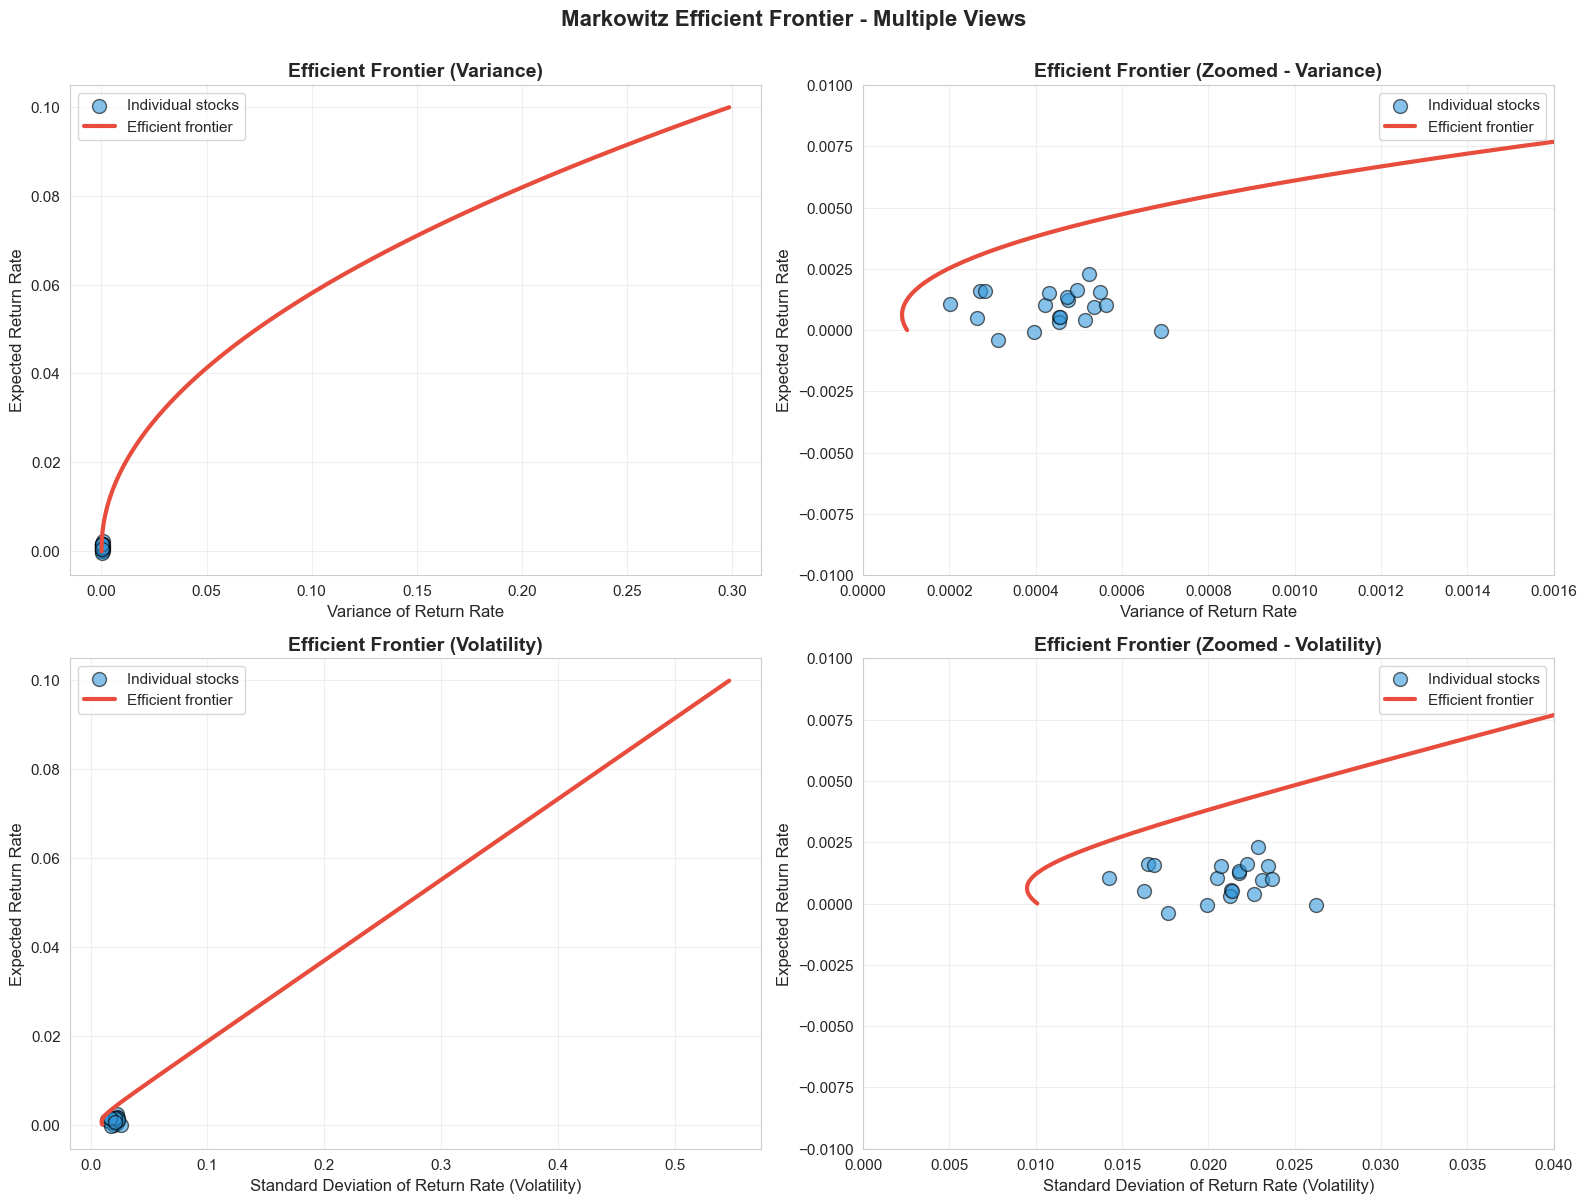

In [ ]:
plots.plot_efficient_frontier(stock_returns_m, stock_returns_s, p_m, p_s)

In [ ]:
def interactive_markowitz(portfolio_idx):
    weights = p_weights[:, portfolio_idx]
    title = (
        f"Skład portfela Markowitza nr {portfolio_idx}\n"
        f"(Zwrot: {p_m[portfolio_idx] * 100:.3f}%, Ryzyko: {p_s[portfolio_idx] * 100:.3f}%)"
    )
    plots.plot_portfolio_composition(weights, stock_names, title=title)


ui_portfolio = interactive(interactive_markowitz, portfolio_idx=(0, len(p_m) - 1, 1))
display(ui_portfolio)

interactive(children=(IntSlider(value=499, description='portfolio_idx', max=999), Output()), _dom_classes=('wi…

## 4. Teoria portfela w praktyce

W ostatnich latach powstaje wiele rozszerzeń klasycznej teorii portfela, które często prowadzą do problemów optymalizacji wymagających złożonych algorytmów rozwiązywania. Wiele modeli wprowadza inne niż wariancja miary ryzyka (m.in. semiwariancja). Wiele modeli odrzuca też założenie o braku ograniczeń _krótkiej sprzedaży_ (ang. short sale), czyli możliwości posiadania ujemnej liczby akcji (w klasycznej teorii portfela dopuszcza się, że współrzędne $p_i$ portfela mogą być ujemne).


## 5. Algorytmy Ewolucyjne


In [ ]:
toolbox = setup_deap(stock_names, stock_returns_m, stock_covariances)

final_pop, logbook = run_nsga2(toolbox, pop_size=200, n_generations=150)

gen	nevals	avg_return 	avg_risk 
0  	0     	0.000922458	0.0127535
1  	176   	0.00104376 	0.0129047
2  	181   	0.00112484 	0.0130027
3  	176   	0.00117486 	0.0129943
4  	173   	0.0012305  	0.0130945
5  	169   	0.00126283 	0.013202 
6  	179   	0.00129148 	0.0132473
7  	187   	0.00130802 	0.0132938
8  	176   	0.00133735 	0.0133124
9  	178   	0.00135939 	0.0134039
10 	183   	0.00138826 	0.013448 
11 	166   	0.00139309 	0.0134862
12 	172   	0.00143633 	0.0135847
13 	183   	0.00146043 	0.0136894
14 	177   	0.00146715 	0.0137654
15 	176   	0.00148192 	0.0138616
16 	175   	0.00148112 	0.0138896
17 	167   	0.00148691 	0.0139383
18 	174   	0.00149352 	0.0139508
19 	173   	0.00148604 	0.0139531
20 	183   	0.00149204 	0.0139731
21 	179   	0.00148962 	0.0139739
22 	182   	0.00151281 	0.0140701
23 	174   	0.0015163  	0.0141187
24 	177   	0.00150211 	0.0141064
25 	174   	0.0015216  	0.0141935
26 	178   	0.00153313 	0.0142967
27 	170   	0.00154399 	0.0143844
28 	179   	0.0015439  	0.0145088
29 	176   

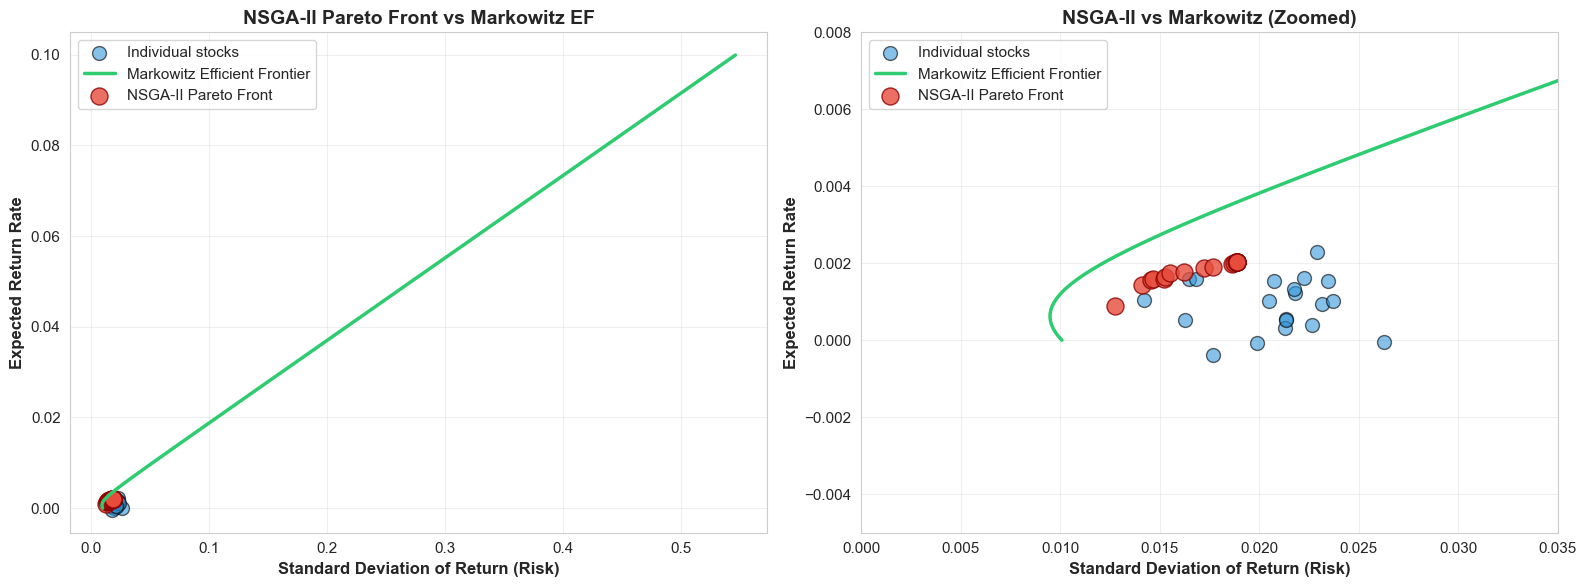

In [ ]:
pareto_front, pareto_returns, pareto_risks = plots.plot_pareto_vs_markowitz(
    final_pop, stock_returns_m, stock_returns_s, p_m, p_s
)

In [ ]:
ui_pareto = interactive(
    lambda portfolio_idx: plots.plot_pareto_portfolio_composition(portfolio_idx, pareto_front, stock_names, p_m, p_s),
    portfolio_idx=(0, len(pareto_front) - 1, 1),
)
display(ui_pareto)

interactive(children=(IntSlider(value=9, description='portfolio_idx', max=18), Output()), _dom_classes=('widge…

## References

[1] Markowitz, H., M., <a href='https://doi.org/10.2307/2975974'>Portfolio Selection</a>, <i>Journal of Finance<i>, vol.7, no.1, 1952, pp.77–91.
